In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root = "/content/drive/MyDrive/4248/proj/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Analysis

## Sanity check

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

In [ ]:
train_path = root + 'raw_data/fulltrain.csv'
test_path = root + 'raw_data/balancedtest.csv'

train_news = pd.read_csv(train_path, header=None, names=['Label', 'Text'])
test_news = pd.read_csv(test_path, header=None, names=['Label', 'Text'])

In [ ]:
#data observation
def quick_check():
    print("training dataset size:")
    print(train_news.shape)
    print(train_news.head(10))

    print("test dataset size:")
    print(test_news.shape)
    print(test_news.head(10))

quick_check()

training dataset size:
(48854, 2)
   Label                                               Text
0      1  A little less than a decade ago, hockey fans w...
1      1  The writers of the HBO series The Sopranos too...
2      1  Despite claims from the TV news outlet to offe...
3      1  After receiving 'subpar' service and experienc...
4      1  After watching his beloved Seattle Mariners pr...
5      1  At a cafeteria-table press conference Monday, ...
6      1  Stunned shock and dismay were just a few of th...
7      1  Speaking with reporters before a game Monday, ...
8      1  Sports journalists and television crews were p...
9      1  SALEM, VAF;or the eighth straight world-histor...
test dataset size:
(3000, 2)
   Label                                               Text
0      1  When so many actors seem content to churn out ...
1      1   In what football insiders are calling an unex...
2      1  In a freak accident following Game 3 of the N....
3      1  North Koreas official news 

In [ ]:
def quick_check():

    print("Checking the training data ...")
    print(train_news.isnull().sum())
    train_news.info()
    print('\n')
    print("Checking the test data ...")
    print(test_news.isnull().sum())
    test_news.info()

    print('\n')
    print("check finished.")

quick_check()

Checking the training data ...
Label    0
Text     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48854 entries, 0 to 48853
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   48854 non-null  int64 
 1   Text    48854 non-null  object
dtypes: int64(1), object(1)
memory usage: 763.5+ KB


Checking the test data ...
Label    0
Text     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   3000 non-null   int64 
 1   Text    3000 non-null   object
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


check finished.


## Label distribution

<Axes: xlabel='Label', ylabel='count'>

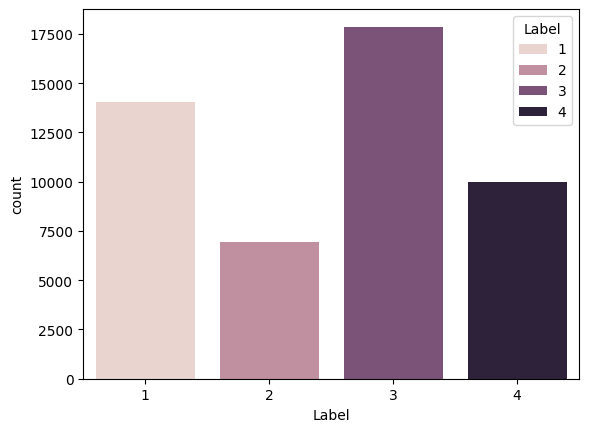

In [ ]:
sns.countplot(x='Label', hue='Label', data=train_news)

<Axes: xlabel='Label', ylabel='count'>

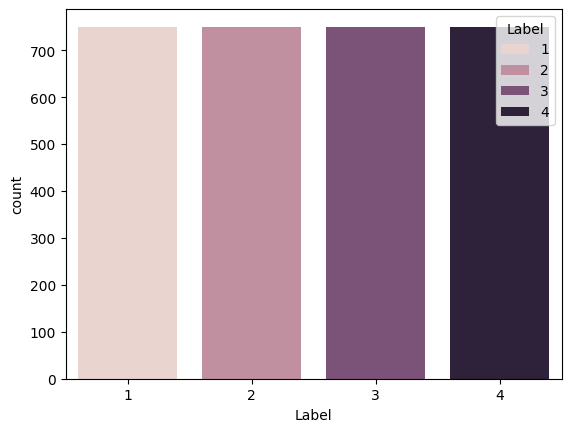

In [ ]:
sns.countplot(x='Label', hue='Label', data=test_news)

Text(0.5, 1.0, 'Label distribution in test set')

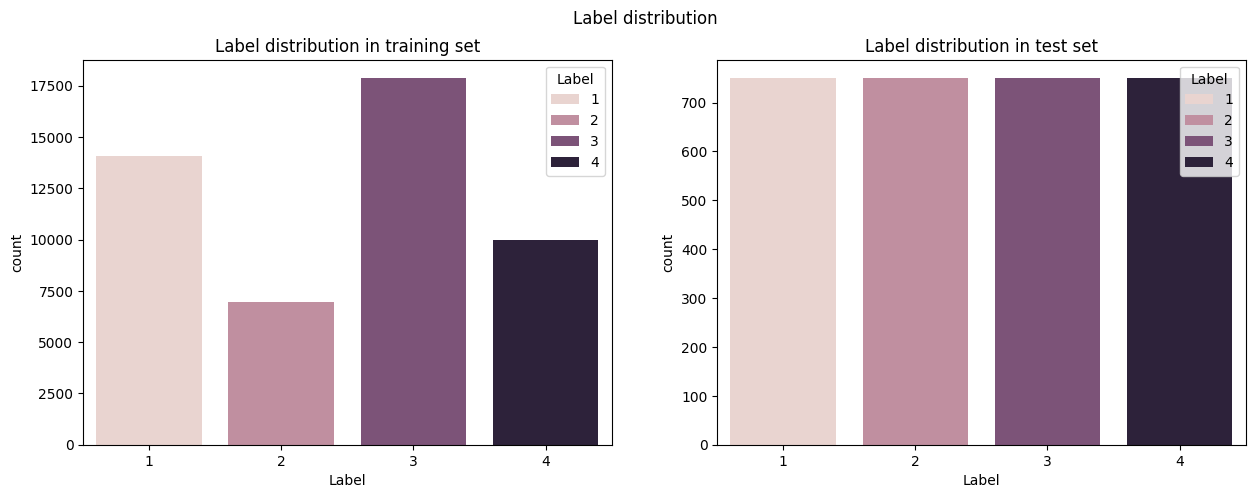

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
fig.suptitle("Label distribution")

# Bulbasaur
sns.countplot(ax=axes[0], x='Label', hue='Label', data=train_news)
axes[0].set_title("Label distribution in training set")

# Charmander
sns.countplot(ax=axes[1], x='Label', hue='Label', data=test_news)
axes[1].set_title("Label distribution in test set")

## Text

In [ ]:
train_news.dtypes

Label     int64
Text     object
dtype: object

In [ ]:
train_news['Text'] = train_news['Text'].astype(str)

In [ ]:
train_news.dtypes

Label     int64
Text     object
dtype: object

### Word count

In [ ]:
def count_words(text):
  return len(text.split())

In [ ]:
train_news['word_count'] = train_news['Text'].apply(lambda x: count_words(x))

In [ ]:
train_news

,Label,Text,word_count
0,1,"A little less than a decade ago, hockey fans w...",146
1,1,The writers of the HBO series The Sopranos too...,122
2,1,Despite claims from the TV news outlet to offe...,705
3,1,After receiving 'subpar' service and experienc...,705
4,1,After watching his beloved Seattle Mariners pr...,173
...,...,...,...
48849,4,The ruling Kuomintang (KMT) has claimed owners...,620
48850,4,The Taipei city government has encouraged the ...,274
48851,4,President Ma Ying-jeou said Friday that a park...,404
48852,4,The families of the four people who were kille...,245


In [ ]:
print("Total number of words = ", train_news['word_count'].sum())
print("Average number of words = ", train_news['word_count'].mean())
print("\n")
print("There are some extreme values: ")
print("Max number of words = ", train_news['word_count'].max())
print("Top 5 number of words = ", train_news.sort_values(['word_count'], ascending=False).head(5))
print("Min number of words = ", train_news['word_count'].min())
print("Least 5 number of words = ", train_news.sort_values(['word_count'], ascending=True).head(5))

print("\n")
print("Excluding extreme values: ")
print("Max number of words = ", train_news['word_count'].quantile(0.9))
print("Min number of words = ", train_news['word_count'].quantile(0.1))

print("\n")
print("Average number of words for each label = ", train_news.groupby('Label')['word_count'].mean())

Total number of words =  26205608
Average number of words =  536.4065992549229


There are some extreme values: 
Max number of words =  117495
Top 5 number of words =         Label                                               Text  word_count
35683      3  Obama Quietly Signs Executive Order to Achieve...      117495
36226      3  22 Medical Studies That Show Vaccines Can Caus...       34267
21664      3  Bradley Manning Gets 35 Years, Dishonorable Di...       30568
31822      3  Florida Court Rules Off Grid Living IllegalBy ...       22666
30941      3  Venezuela Is Out of Food: Heres What an Econom...       22198
Min number of words =  2
Least 5 number of words =         Label                      Text  word_count
353        1           Denver Broncos            2
8886       1         Seattle Seahawks            2
8885       1          Atlanta Falcons            2
8884       1        Minnesota Vikings            2
31508      3  Withdraw ConsentYouTube            2


Excluding extrem

<Axes: ylabel='Density'>

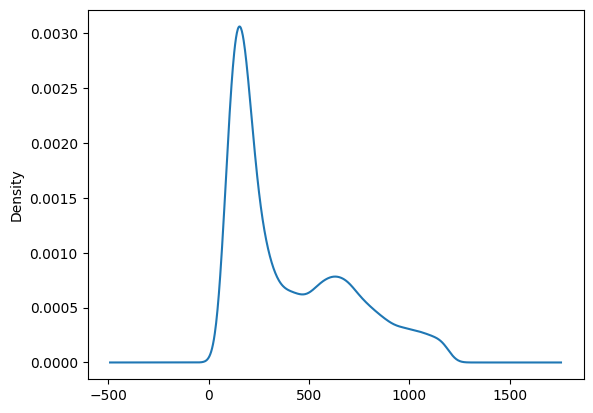

In [ ]:
train_news[(train_news['word_count']<=1194) & (train_news['word_count']>=71)].word_count.plot(kind='kde')

# Preprocessing

## Stopwords

In [ ]:
!pip install stop_words

  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=1d8c474374bfd319df0939e5c1e0066d687632991f3eafe0c70e511e02ded1ce
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop_words


In [ ]:
from stop_words import get_stop_words
stopword_list = get_stop_words('english')
print(len(stopword_list))
print(stopword_list)

174
['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves'

In [ ]:
def remove_stopwords(text):
  word_list = [w for w in text.split() if w not in stopword_list]
  return " ".join(word_list)

## Lowercase

In [ ]:
def convert_lower(text):
  return text.lower()

## Numbers

In [ ]:
def remove_numbers(text):
  result = re.sub(r'\d+', '', text)
  return result

## Punctuations

In [ ]:
string.punctuation
def remove_punc(text):
  trans = str.maketrans('', '', string.punctuation)
  return text.translate(trans)

## White spaces

In [ ]:
def remove_whitespace(text):
  return " ".join(text.split())

## Applying all above

In [ ]:
def clean_text(text):
  out = convert_lower(text)
  out = remove_stopwords(out)
  out = remove_numbers(out)
  out = remove_punc(out)
  out = remove_whitespace(out)
  return out

In [ ]:
train_news['cleaned_text'] = train_news['Text'].apply(lambda x: clean_text(x))

In [ ]:
train_news.head()

,Label,Text,word_count,cleaned_text
0,1,"A little less than a decade ago, hockey fans w...",146,little less decade ago hockey fans blessed sla...
1,1,The writers of the HBO series The Sopranos too...,122,writers hbo series sopranos took another darin...
2,1,Despite claims from the TV news outlet to offe...,705,despite claims tv news outlet offer nonstop ne...
3,1,After receiving 'subpar' service and experienc...,705,receiving subpar service experiencing unusuall...
4,1,After watching his beloved Seattle Mariners pr...,173,watching beloved seattle mariners prevail san ...


# Analysis after cleaning

In [ ]:
def get_wordls(text):
  return text.split(' ')

In [ ]:
train_news[train_news.Label==1].cleaned_text.apply(lambda x: get_wordls(x))

0        [little, less, decade, ago, hockey, fans, bles...
1        [writers, hbo, series, sopranos, took, another...
2        [despite, claims, tv, news, outlet, offer, non...
3        [receiving, subpar, service, experiencing, unu...
4        [watching, beloved, seattle, mariners, prevail...
                               ...                        
14042    [tularosa, new, mexico, last, week, stayathome...
14043    [zsa, zsa, eva, gabor, wellknown, star, stage,...
14044    [locker, room, interview, prior, game, sacrame...
14045    [president, clintons, approval, rating, skyroc...
14046    [three, decades, song, charttopping, smash, be...
Name: cleaned_text, Length: 14047, dtype: object

In [ ]:
from itertools import chain
from collections import Counter

In [ ]:
def get_top10(label):
  label_df = train_news[train_news['Label']==label][['cleaned_text']]
  label_df['word_ls'] = label_df['cleaned_text'].apply(lambda x: get_wordls(x))
  ls_of_ls = label_df['word_ls'].to_list()
  comp_word_ls = list(chain(*ls_of_ls))
  filter_words = [w for w in comp_word_ls if len(w) > 2]
  word_count_dict = Counter(filter_words)
  word = list(word_count_dict.keys())
  count = list(word_count_dict.values())
  word_count_df = pd.DataFrame({'word': word, 'freq': count})
  word_count_df1 = word_count_df.sort_values(['freq'], ascending=False)
  top10_words = word_count_df1.head(10)
  ax = sns.barplot(data=top10_words, y='word', x='freq')
  for i in ax.containers:
    ax.bar_label(i)
  return top10_words

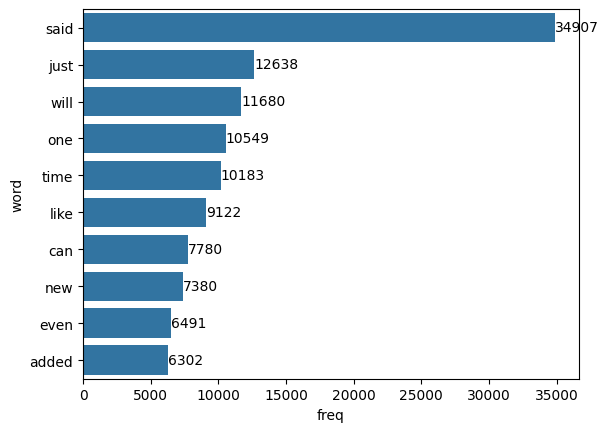

In [ ]:
_ = get_top10(1)

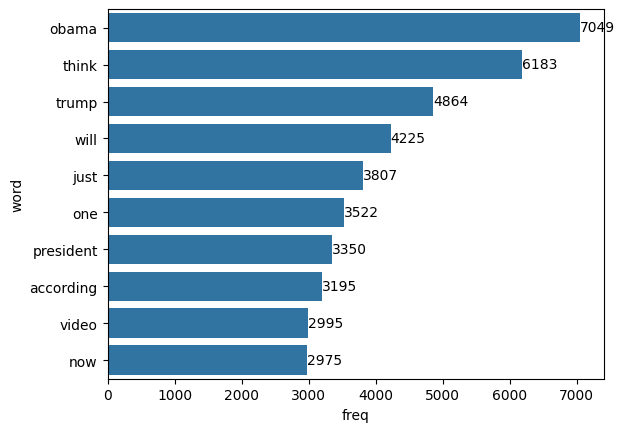

In [ ]:
_ = get_top10(2)

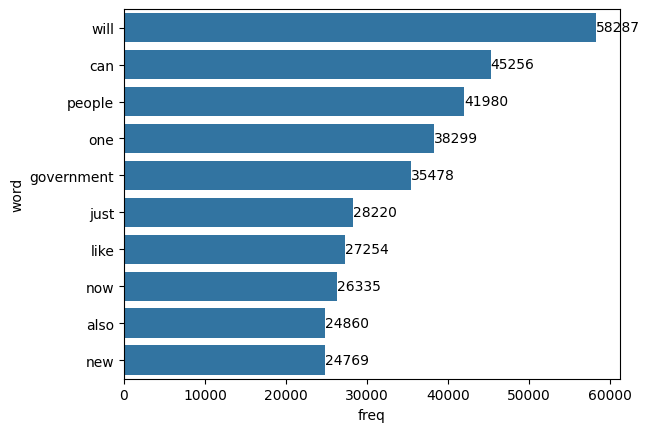

In [ ]:
_ = get_top10(3)

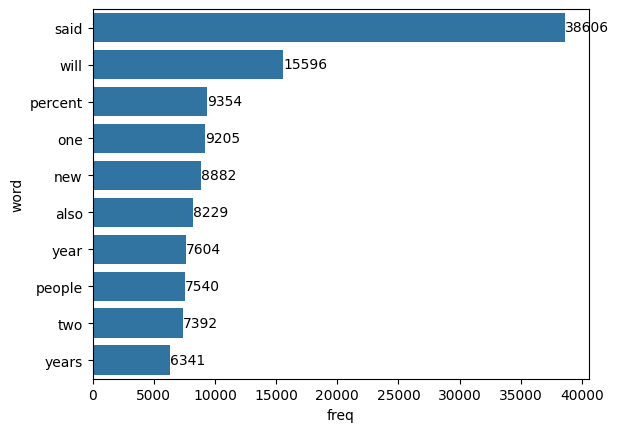

In [ ]:
_ = get_top10(4)

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15), sharey=False)
fig.suptitle("Label distribution")

# Bulbasaur

sns.countplot(ax=axes[0], x='Label', hue='Label', data=train_news)
axes[0].set_title("Label distribution in training set")

# Charmander
sns.countplot(ax=axes[1], x='Label', hue='Label', data=test_news)
axes[1].set_title("Label distribution in test set")

In [ ]:
def get_top10(label, axx, axy):
  cat = {1:'satire',2:'hoax',3:'propaganda',4:'reliable'}
  label_df = train_news[train_news['Label']==label][['cleaned_text']]
  label_df['word_ls'] = label_df['cleaned_text'].apply(lambda x: get_wordls(x))
  ls_of_ls = label_df['word_ls'].to_list()
  comp_word_ls = list(chain(*ls_of_ls))
  filter_words = [w for w in comp_word_ls if len(w) > 2]
  word_count_dict = Counter(filter_words)
  word = list(word_count_dict.keys())
  count = list(word_count_dict.values())
  word_count_df = pd.DataFrame({'word': word, 'freq': count})
  word_count_df1 = word_count_df.sort_values(['freq'], ascending=False)
  top10_words = word_count_df1.head(10)
  ax = sns.barplot(ax=axes[axx, axy], data=top10_words, y='word', x='freq')
  for i in ax.containers:
    ax.bar_label(i)
  axes[axx, axy].set_title("class {} ({})".format(label, cat[label]))
  return top10_words

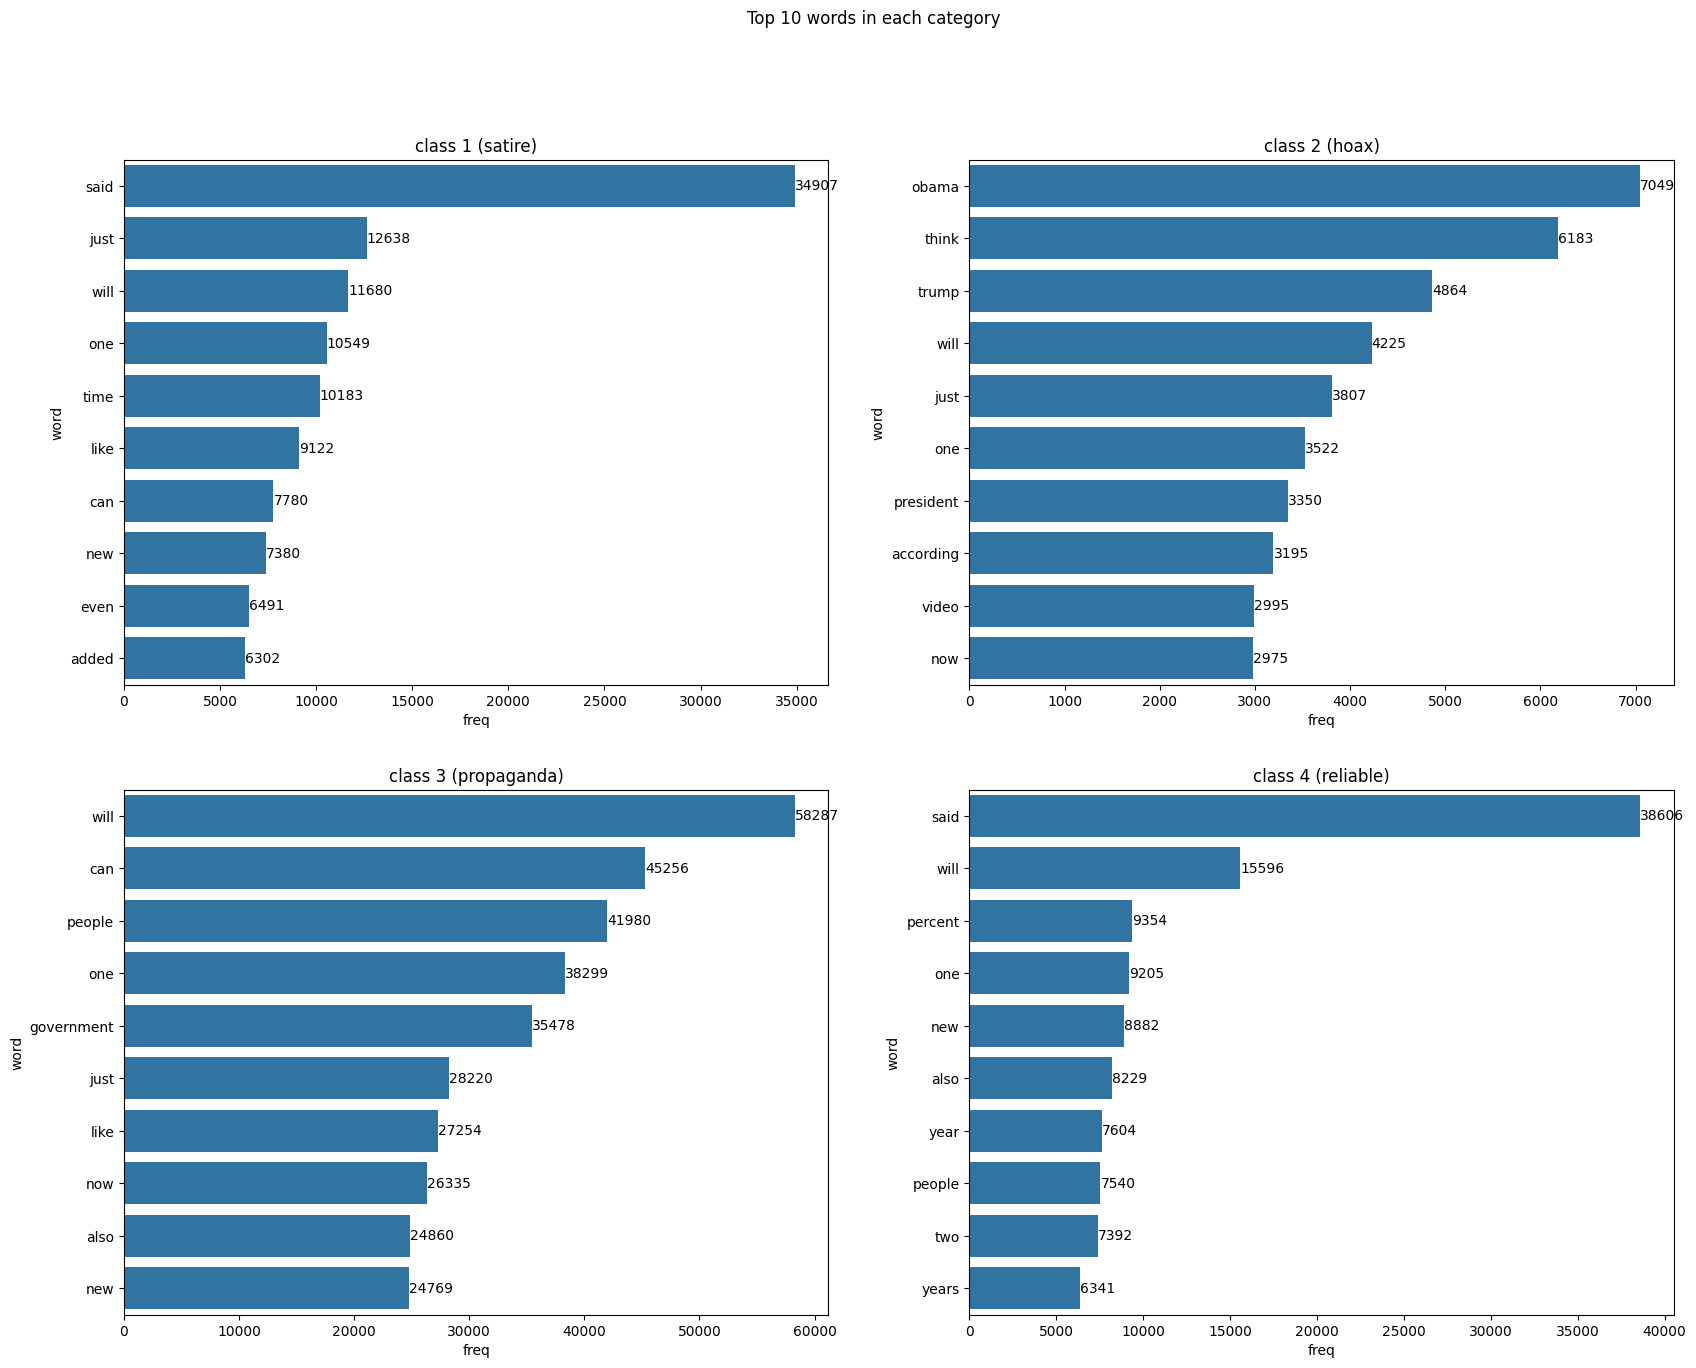

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 15), sharey=False)
fig.suptitle("Top 10 words in each category")

count = 1
for i in [0,1]:
  for j in [0,1]:
    get_top10(count, i, j)
    count += 1